<img src="http://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_torchtrt_efficientnet/nvidia_logo.png" width="90px">

# PySpark PyTorch Inference

### Image Classification

In this notebook, we will train an MLP to perform image classification on FashionMNIST, and load it for distributed inference with Spark.

Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html  

We also demonstrate accelerated inference via Torch-TensorRT model compilation.   

In [1]:
import torch
import os
import shutil
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
os.mkdir('models') if not os.path.exists('models') else None

In [3]:
torch.__version__

'2.5.1+cu124'

### Load Dataset

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="datasets/data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="datasets/data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = torch.flatten(X, start_dim=1, end_dim=-1)

        # Zero gradients
        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = torch.flatten(X, start_dim=1, end_dim=-1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


loss: 2.298206  [   64/60000]
loss: 2.283203  [ 6464/60000]
loss: 2.262282  [12864/60000]
loss: 2.259791  [19264/60000]
loss: 2.240928  [25664/60000]
loss: 2.218922  [32064/60000]
loss: 2.225280  [38464/60000]
loss: 2.193091  [44864/60000]
loss: 2.194699  [51264/60000]
loss: 2.157922  [57664/60000]
Test Error: 
 Accuracy: 38.6%, Avg loss: 2.149652 

Epoch 2
-------------------------------
loss: 2.164765  [   64/60000]
loss: 2.153999  [ 6464/60000]
loss: 2.094229  [12864/60000]
loss: 2.107332  [19264/60000]
loss: 2.060189  [25664/60000]
loss: 2.009164  [32064/60000]
loss: 2.033063  [38464/60000]
loss: 1.954014  [44864/60000]
loss: 1.968186  [51264/60000]
loss: 1.892358  [57664/60000]
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.883826 

Epoch 3
-------------------------------
loss: 1.922989  [   64/60000]
loss: 1.895849  [ 6464/60000]
loss: 1.767882  [12864/60000]
loss: 1.804950  [19264/60000]
loss: 1.702711  [25664/60000]
loss: 1.664090  [32064/60000]
loss: 1.682484  [38464/60000]
loss: 

### Save Model State Dict
This saves the serialized object to disk using pickle.

In [12]:
torch.save(model.state_dict(), "models/model.pt")
print("Saved PyTorch Model State to models/model.pt")

Saved PyTorch Model State to models/model.pt


### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python). 

In [13]:
scripted = torch.jit.script(model)
scripted.save("models/ts_model.pt")
print("Saved TorchScript Model to models/ts_model.pt")

Saved TorchScript Model to models/ts_model.pt


### Load Model State

In [14]:
model_from_state = NeuralNetwork().to(device)
model_from_state.load_state_dict(torch.load("models/model.pt", weights_only=True))

<All keys matched successfully>

In [15]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = torch.flatten(x.to(device), start_dim=1, end_dim=-1)
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Torchscript Model

In [16]:
ts_model = torch.jit.load("models/ts_model.pt")

In [17]:
x, y = test_data[0][0], test_data[0][1]

In [ ]:
with torch.no_grad():
    pred = ts_model(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Compile using the Torch JIT Compiler
This leverages the [Torch-TensorRT inference compiler](https://pytorch.org/TensorRT/) for accelerated inference on GPUs using the `torch.compile` JIT interface under the hood. The compiler stack returns a [boxed-function](http://blog.ezyang.com/2020/09/lets-talk-about-the-pytorch-dispatcher/) that triggers compilation on the first call.  

Modules compiled in this fashion are [not serializable with pickle](https://github.com/pytorch/pytorch/issues/101107#issuecomment-1542688089), so we cannot send the compiled model directly to Spark. 

(You may see a warning about modelopt quantization. This is safe to ignore, as [implicit quantization](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#intro-quantization) is deprecated in the latest TensorRT. See [this link](https://pytorch.org/TensorRT/tutorials/_rendered_examples/dynamo/vgg16_fp8_ptq.html) for a guide to explicit quantization.)

In [19]:
import torch_tensorrt as trt
import time

In [20]:
# Optional: set the filename for the TensorRT timing cache
timestamp = time.time()
timing_cache = f"/tmp/timing_cache-{timestamp}.bin"
with open(timing_cache, "wb") as f:
    pass

In [21]:
inputs_bs1 = torch.randn((10, 784), dtype=torch.float).to("cuda")
# This indicates dimension 0 of inputs_bs1 is dynamic whose range of values is [1, 50]. 
torch._dynamo.mark_dynamic(inputs_bs1, 0, min=1, max=64)
trt_model = trt.compile(
    model,
    ir="torch_compile",
    inputs=inputs_bs1,
    enabled_precisions={torch.float},
    timing_cache_path=timing_cache,
)

In [22]:
stream = torch.cuda.Stream()
with torch.no_grad(), torch.cuda.stream(stream):
    pred = trt_model(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Compile using the Torch-TensorRT AOT Compiler
Alternatively, use the Torch-TensorRT Dynamo backend for Ahead-of-Time (AOT) compilation to eagerly optimize the model in an explicit compilation phase. We first export the model to produce a traced graph representing the Tensor computation in an AOT fashion, which produces a `ExportedProgram` object which can be [serialized and reloaded](https://pytorch.org/TensorRT/user_guide/saving_models.html). We can then compile this IR using the Torch-TensorRT AOT compiler for inference.   

[Read the docs](https://pytorch.org/TensorRT/user_guide/torch_tensorrt_explained.html) for more information on JIT vs AOT compilation.

In [23]:
example_inputs = (torch.randn((10, 784), dtype=torch.float).to("cuda"),)

# Mark dim 1 (batch size) as dynamic
batch = torch.export.Dim("batch", min=1, max=64)
# Produce traced graph in ExportedProgram format
exp_program = torch.export.export(model_from_state, args=example_inputs, dynamic_shapes={"x": {0: batch}})
# Compile the traced graph to produce an optimized module
trt_gm = trt.dynamo.compile(exp_program, tuple(example_inputs), enabled_precisions={torch.float}, timing_cache_path=timing_cache)

In [24]:
print(type(exp_program))
print(type(trt_gm))

<class 'torch.export.exported_program.ExportedProgram'>
<class 'torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl'>


In [25]:
stream = torch.cuda.Stream()
with torch.no_grad(), torch.cuda.stream(stream):
    trt_gm(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


We can run the optimized module with a few different batch sizes (without recompilation!):

In [ ]:
inputs = (torch.randn((10, 784), dtype=torch.float).cuda(),)
inputs_bs1 = (torch.randn((1, 784), dtype=torch.float).cuda(),)
inputs_bs50 = (torch.randn((50, 784), dtype=torch.float).cuda(),)

stream = torch.cuda.Stream()
with torch.no_grad(), torch.cuda.stream(stream):
    print("Output shapes:")
    print(trt_gm(*inputs).shape)
    print(trt_gm(*inputs_bs1).shape)
    print(trt_gm(*inputs_bs50).shape)

Output shapes:
torch.Size([10, 10])
torch.Size([1, 10])
torch.Size([50, 10])


We can serialize the ExportedProgram (a traced graph representing the model's forward function) using `torch.export.save` to be recompiled at a later date.

In [ ]:
torch.export.save(exp_program, "models/trt_model.ep")
print("Saved ExportedProgram to models/trt_model.ep")

Saved ExportedProgram to models/trt_model.ep


## PySpark

In [28]:
from pyspark.sql.functions import col, struct, pandas_udf, array
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkConf

In [29]:
import pandas as pd
import numpy as np
import json
import os

Check the cluster environment to handle any platform-specific Spark configurations.

In [30]:
on_databricks = os.environ.get("DATABRICKS_RUNTIME_VERSION", False)
on_dataproc = os.environ.get("DATAPROC_IMAGE_VERSION", False)
on_standalone = not (on_databricks or on_dataproc)

#### Create Spark Session

For local standalone clusters, we'll connect to the cluster and create the Spark Session.  
For CSP environments, Spark will either be preconfigured (Databricks) or we'll need to create the Spark Session (Dataproc).

In [31]:
conf = SparkConf()

if 'spark' not in globals():
    if on_standalone:
        import socket
        conda_env = os.environ.get("CONDA_PREFIX")
        hostname = socket.gethostname()
        conf.setMaster(f"spark://{hostname}:7077")
        conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
        conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")

    conf.set("spark.executor.cores", "8")
    conf.set("spark.task.resource.gpu.amount", "0.125")
    conf.set("spark.executor.resource.gpu.amount", "1")
    conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
    conf.set("spark.python.worker.reuse", "true")
    
spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

25/02/04 13:50:47 WARN Utils: Your hostname, cb4ae00-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.47.100 instead (on interface eno1)
25/02/04 13:50:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/04 13:50:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Create Spark DataFrame from Pandas DataFrame

In [32]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [ ]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [34]:
pdf784 = pd.DataFrame(data)
pdf784

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.121569,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [35]:
# 1 column of array<float>
pdf1 = pd.DataFrame()
pdf1['data'] = pdf784.values.tolist()
pdf1

,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.00..."
...,...
9995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Create dataframes with a single column of 784 floats and 784 separate columns.

In [36]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf1, schema).repartition(8)
df.schema

CPU times: user 185 ms, sys: 28.9 ms, total: 214 ms
Wall time: 1.5 s


StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [37]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField(str(x), FloatType(), True) for x in range(784)])
df784 = spark.createDataFrame(pdf784, schema).repartition(8)
df.schema

CPU times: user 66.9 ms, sys: 11.2 ms, total: 78.1 ms
Wall time: 875 ms


StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [38]:
%%time
data_path_1 = "spark-dl-datasets/fashion_mnist_1"
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-datasets")
    data_path_1 = "dbfs:/FileStore/" + data_path_1

df.write.mode("overwrite").parquet(data_path_1)

25/02/04 13:50:51 WARN TaskSetManager: Stage 0 contains a task of very large size (4030 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 2.09 ms, sys: 1.6 ms, total: 3.69 ms
Wall time: 1.71 s


In [39]:
%%time
data_path_784 = "spark-dl-datasets/fashion_mnist_784"
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-datasets")
    data_path_784 = "dbfs:/FileStore/" + data_path_784

df784.write.mode("overwrite").parquet(data_path_784)

25/02/04 13:50:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


25/02/04 13:50:53 WARN TaskSetManager: Stage 3 contains a task of very large size (7847 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 2.94 ms, sys: 61 μs, total: 3 ms
Wall time: 943 ms


## Inference using Spark DL API

Distributed inference using the PySpark [predict_batch_udf](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.functions.predict_batch_udf.html#pyspark.ml.functions.predict_batch_udf):

- predict_batch_fn uses PyTorch APIs to load the model and return a predict function which operates on numpy arrays 
- predict_batch_udf will convert the Spark DataFrame columns into numpy input batches for the predict function

### 1 column of 784 float

In [40]:
df = spark.read.parquet(data_path_1)
len(df.columns)

1

In [41]:
# A resource warning may occur due to unclosed file descriptors used by TensorRT across multiple PySpark daemon processes.
# These can be safely ignored as the resources will be cleaned up when the worker processes terminate.

import warnings
warnings.simplefilter("ignore", ResourceWarning)

In [42]:
# get absolute path to model
model_path = "{}/models/trt_model.ep".format(os.getcwd())

# For cloud environments, copy the model to the distributed file system.
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-models")
    dbfs_model_path = "/dbfs/FileStore/spark-dl-models/model.pt"
    shutil.copy(model_path, dbfs_model_path)
    model_path = dbfs_model_path
elif on_dataproc:
    # GCS is mounted at /mnt/gcs by the init script
    models_dir = "/mnt/gcs/spark-dl/models"
    os.mkdir(models_dir) if not os.path.exists(models_dir) else None
    gcs_model_path = models_dir + "/trt_model.ep"
    shutil.copy(model_path, gcs_model_path)
    model_path = gcs_model_path

In [43]:
def predict_batch_fn():
    import torch
    import torch_tensorrt as trt
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        raise ValueError("This function uses the TensorRT model which requires a GPU device")

    example_inputs = (torch.randn((50, 784), dtype=torch.float).to("cuda"),)
    exp_program = torch.export.load(model_path)
    trt_gm = trt.dynamo.compile(exp_program,
                                tuple(example_inputs),
                                enabled_precisions={torch.float},
                                workspace_size=1<<30)

    def predict(inputs: np.ndarray):
        stream = torch.cuda.Stream()
        with torch.no_grad(), torch.cuda.stream(stream):
            # use array to combine columns into tensors
            torch_inputs = torch.from_numpy(inputs).to(device)
            outputs = trt_gm(torch_inputs)
            return outputs.detach().cpu().numpy()

    return predict

In [44]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [45]:
%%time
# first pass compiles and caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 167 ms, sys: 76.2 ms, total: 243 ms
Wall time: 10.9 s


In [46]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 234 ms, sys: 64.1 ms, total: 298 ms
Wall time: 685 ms


In [47]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 403 ms, sys: 60.1 ms, total: 463 ms
Wall time: 809 ms


### Check predictions

In [48]:
predictions = preds[0].preds
img = preds[0].data

In [49]:
import matplotlib.pyplot as plt
import numpy as np

In [50]:
img = np.array(img).reshape(28,28)

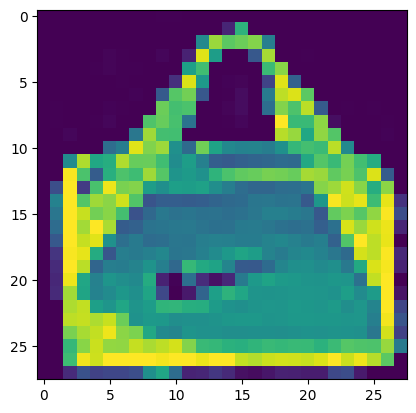

In [51]:
plt.figure()
plt.imshow(img)
plt.show()

In [52]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[-1.0776339769363403, -3.4281859397888184, 1.0321333408355713, -2.1151161193847656, 0.7665405869483948, 0.7089913487434387, 0.6775667071342468, 0.3138602077960968, 2.9969606399536133, 0.7927607297897339]
predicted label: Bag


### 784 columns of float

In [53]:
df = spark.read.parquet(data_path_784)
len(df.columns)

784

In [54]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 225 ms, sys: 91.1 ms, total: 316 ms
Wall time: 3.16 s


In [55]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 283 ms, sys: 67.8 ms, total: 351 ms
Wall time: 1.47 s


In [56]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 543 ms, sys: 65.1 ms, total: 608 ms
Wall time: 1.36 s


### Check predictions

In [57]:
preds = df.withColumn("preds", mnist(array(*df.columns))).limit(10).toPandas()

In [58]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [59]:
import matplotlib.pyplot as plt
import numpy as np

In [60]:
img = np.array(img).reshape(28,28)

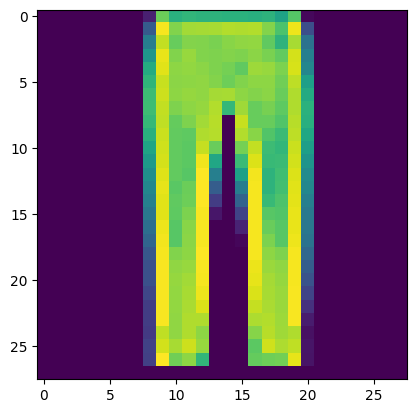

In [61]:
plt.figure()
plt.imshow(img)
plt.show()

In [62]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[ 2.44647     3.8623989   0.14587203  3.2146688   1.0799949  -2.5363288
  0.86715794 -3.8287208  -2.02238    -2.9016623 ]
predicted label: Trouser


In [63]:
# This will clear the engine cache (containing previously compiled TensorRT engines) and resets the CUDA Context.
torch._dynamo.reset()

## Using Triton Inference Server
In this section, we demonstrate integration with the [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server), an open-source, GPU-accelerated serving solution for DL.  
We use [PyTriton](https://github.com/triton-inference-server/pytriton), a Flask-like framework that handles client/server communication with the Triton server.  

The process looks like this:
- Distribute a PyTriton task across the Spark cluster, instructing each node to launch a Triton server process.
- Define a Triton inference function, which contains a client that binds to the local server on a given node and sends inference requests.
- Wrap the Triton inference function in a predict_batch_udf to launch parallel inference requests using Spark.
- Finally, distribute a shutdown signal to terminate the Triton server processes on each node.

<img src="../images/spark-server.png" alt="drawing" width="700"/>

In [64]:
from functools import partial

Import the helper class from server_utils.py:

In [65]:
sc.addPyFile("server_utils.py")

from server_utils import TritonServerManager

Define the Triton Server function:

In [66]:
def triton_server(ports, model_path):
    import time
    import signal
    import numpy as np
    import torch
    from torch import nn
    import torch_tensorrt as trt
    from pytriton.decorators import batch
    from pytriton.model_config import DynamicBatcher, ModelConfig, Tensor
    from pytriton.triton import Triton, TritonConfig
    from pyspark import TaskContext

    print(f"SERVER: Initializing model on worker {TaskContext.get().partitionId()}.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    exp_program = torch.export.load(model_path)
    example_inputs = (torch.randn((50, 784), dtype=torch.float).to("cuda"),)
    trt_gm = trt.dynamo.compile(exp_program,
                                tuple(example_inputs),
                                enabled_precisions={torch.float},
                                workspace_size=1<<30)

    print("SERVER: Compiled model.")

    @batch
    def _infer_fn(**inputs):
        images = inputs["images"]
        if len(images) != 1:
            images = np.squeeze(images)
        stream = torch.cuda.Stream()
        with torch.no_grad(), torch.cuda.stream(stream):
            torch_inputs = torch.from_numpy(images).to(device)
            outputs = trt_gm(torch_inputs)
            return {
                "labels": outputs.cpu().numpy(),
            }
        
    workspace_path = f"/tmp/triton_{time.strftime('%m_%d_%M_%S')}"
    triton_conf = TritonConfig(http_port=ports[0], grpc_port=ports[1], metrics_port=ports[2])
    with Triton(config=triton_conf, workspace=workspace_path) as triton:
        triton.bind(
            model_name="ImageClassifier",
            infer_func=_infer_fn,
            inputs=[
                Tensor(name="images", dtype=np.float32, shape=(-1,)),
            ],
            outputs=[
                Tensor(name="labels", dtype=np.float32, shape=(-1,)),
            ],
            config=ModelConfig(
                max_batch_size=64,
                batcher=DynamicBatcher(max_queue_delay_microseconds=5000),  # 5ms
            ),
            strict=True,
        )

        def _stop_triton(signum, frame):
            # The server manager sends SIGTERM to stop the server; this function ensures graceful cleanup.
            print("SERVER: Received SIGTERM. Stopping Triton server.")
            triton.stop()

        signal.signal(signal.SIGTERM, _stop_triton)

        print("SERVER: Serving inference")
        triton.serve()

#### Start Triton servers  

The `TritonServerManager` will handle the lifecycle of Triton server instances across the Spark cluster:
- Find available ports for HTTP/gRPC/metrics
- Deploy a server on each node via stage-level scheduling
- Gracefully shutdown servers across nodes

In [68]:
model_name = "ImageClassifier"
server_manager = TritonServerManager(model_name=model_name, model_path=model_path)

In [ ]:
# Returns {'hostname', (server_pid, [http_port, grpc_port, metrics_port])}
server_manager.start_servers(triton_server)

2025-02-07 11:03:44,809 - INFO - Requesting stage-level resources: (cores=5, gpu=1.0)
2025-02-07 11:03:44,810 - INFO - Starting 1 servers.


{'cb4ae00-lcedt': (2020631, [7000, 7001, 7002])}

#### Define client function

Get the hostname -> url mapping from the server manager:

In [ ]:
host_to_http_url = server_manager.host_to_http_url  # or server_manager.host_to_grpc_url

Define the Triton inference function, which returns a predict function for batch inference through the server:

In [71]:
def triton_fn(model_name, host_to_url):
    import socket
    from pytriton.client import ModelClient

    url = host_to_url[socket.gethostname()]
    print(f"Connecting to Triton model {model_name} at {url}.")

    def infer_batch(inputs):
        with ModelClient(url, model_name, inference_timeout_s=240) as client:
            result_data = client.infer_batch(inputs)
            return result_data["labels"]
        
    return infer_batch

In [73]:
mnist = predict_batch_udf(partial(triton_fn, model_name=model_name, host_to_url=host_to_http_url),
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

#### Run inference

In [72]:
df = spark.read.parquet(data_path_1)
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [74]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 157 ms, sys: 47.6 ms, total: 205 ms
Wall time: 2.49 s


In [75]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 183 ms, sys: 60.3 ms, total: 243 ms
Wall time: 1.49 s


In [76]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 383 ms, sys: 43.9 ms, total: 427 ms
Wall time: 1.6 s


Predicted label: Bag


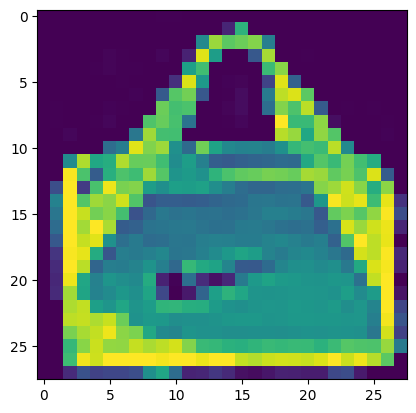

In [77]:
# Sample prediction
sample = preds[0]
predictions = sample.preds
img = sample.data

img = np.array(img).reshape(28,28)
plt.figure()
plt.imshow(img)

print("Predicted label:", classes[np.argmax(predictions)])

#### Stop Triton Server on each executor

In [ ]:
server_manager.stop_servers()

2025-02-04 14:00:18,330 - INFO - Requesting stage-level resources: (cores=5, gpu=1.0)
2025-02-04 14:00:28,520 - INFO - Sucessfully stopped 1 servers.                 


[True]

In [79]:
if not on_databricks: # on databricks, spark.stop() puts the cluster in a bad state
    spark.stop()